# **Preperation and Evaluation Functions**

In [219]:
%pip install nltk datasets torch tqdm


In [220]:
# libraries
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import defaultdict
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
nltk.download('punkt')
from datasets import load_dataset


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [221]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [222]:
import re

def retrieve_data(max_length=30):
    dataset = load_dataset("wmt14", "de-en")

    raw_subset = dataset["train"].select(range(200000))

    def clean_sentence(sentence):
        # Lowercase the sentence
        sentence = sentence.lower()
        # Remove punctuation using regular expressions
        sentence = re.sub(r"[^\w\s]", "", sentence)
        # Remove extra spaces
        sentence = re.sub(r"\s+", " ", sentence)
        return sentence

    def is_short(example):
        # Clean sentences before checking length
        en_sentence = clean_sentence(example["translation"]["en"])
        de_sentence = clean_sentence(example["translation"]["de"])
        return len(en_sentence.split()) <= max_length and len(de_sentence.split()) <= max_length


    filtered = raw_subset.filter(is_short)

    train_data = filtered.select(range(50000))
    val_data = filtered.select(range(50000, 55000))
    test_data = filtered.select(range(55000, 60000))

    return {
        "train": train_data,
        "validation": val_data,
        "test": test_data
    }

In [223]:
dataset = retrieve_data()
train_data = dataset["train"]
pairs = [[ex["translation"]["en"], ex["translation"]["de"]] for ex in train_data]
print(len(pairs))  # Add this line to print the size

50000


In [224]:
# Install required libraries
%pip install nltk bert-score

# Import
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [225]:
def evaluate_all_metrics(model, pairs, eng_vocab, german_vocab, max_len=20):
    model.eval()
    smooth = SmoothingFunction().method4
    bleu_scores = []
    meteor_scores = []
    preds, refs = [], []

    for eng, ger in pairs:
        try:
            pred = translate_sentence(eng, model, eng_vocab, german_vocab, max_len=max_len)

            print(f"\nEN: {eng}")
            print(f"GT: {ger}")
            print(f"PR: {pred}")

            hyp = pred.strip().split()
            ref = ger.strip().split()

            if not hyp or not ref:
                print("Skipping empty hypothesis or reference.")
                continue

            bleu = sentence_bleu([ref], hyp, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
            meteor = meteor_score([ger.split()], pred.split())

            bleu_scores.append(bleu)
            meteor_scores.append(meteor)
            preds.append(pred)
            refs.append(ger)
        except Exception as e:
            print(f"Error: {e}")
            continue

    if len(preds) == 0 or len(refs) == 0:
        print("No valid predictions or references. Check model output.")
        return {}

    print("\nComputing BERTScore...")
    P, R, F1 = bert_score(preds, refs, lang="de", verbose=True)

    return {
        "BLEU": sum(bleu_scores) / len(bleu_scores),
        "METEOR": sum(meteor_scores) / len(meteor_scores),
        "BERT Precision": float(P.mean()),
        "BERT Recall": float(R.mean()),
        "BERT F1": float(F1.mean())
    }


In [226]:
def tokenize(sentence:str)->(list):
    return sentence.lower().split()

def build_vocab(sentences:list)->(dict):
    # building a vocabullary so each word had an index
    # <pad> - to align sentences
    # <sos> - "start of sentence" (inserted before each sentence)
    # <eos> - "end of sentence" (inserted at the end)
    vocab = {"<pad>":0, "<sos>":1, "<eos>":2,}
    idx = 3 # starting point
    for sentence in sentences:
        for word in tokenize(sentence):
            if word not in vocab:
                vocab[word] = idx
                idx+=1
    return vocab


In [227]:
# creating eng and ger vocabs
eng_vocab = build_vocab([n[0] for n in pairs])
german_vocab = build_vocab([n[1] for n in pairs])
print(eng_vocab)
print(german_vocab)

{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'resumption': 3, 'of': 4, 'the': 5, 'session': 6, 'you': 7, 'have': 8, 'requested': 9, 'a': 10, 'debate': 11, 'on': 12, 'this': 13, 'subject': 14, 'in': 15, 'course': 16, 'next': 17, 'few': 18, 'days,': 19, 'during': 20, 'part-session.': 21, 'please': 22, 'rise,': 23, 'then,': 24, 'for': 25, "minute'": 26, 's': 27, 'silence.': 28, '(the': 29, 'house': 30, 'rose': 31, 'and': 32, 'observed': 33, 'silence)': 34, 'madam': 35, 'president,': 36, 'point': 37, 'order.': 38, 'will': 39, 'be': 40, 'aware': 41, 'from': 42, 'press': 43, 'television': 44, 'that': 45, 'there': 46, 'been': 47, 'number': 48, 'bomb': 49, 'explosions': 50, 'killings': 51, 'sri': 52, 'lanka.': 53, 'yes,': 54, 'mr': 55, 'evans,': 56, 'i': 57, 'feel': 58, 'an': 59, 'initiative': 60, 'type': 61, 'just': 62, 'suggested': 63, 'would': 64, 'entirely': 65, 'appropriate.': 66, 'if': 67, 'agrees,': 68, 'shall': 69, 'do': 70, 'as': 71, 'evans': 72, 'has': 73, 'suggested.': 74, 'like': 75, 'your

In [228]:
def sentence_to_indices(sentence:str, vocab:dict)->(list):
    tokens = tokenize(sentence)
    return [vocab["<sos>"]]+[vocab[n] for n in tokens]+[vocab["<eos>"]]

eng_indices = [sentence_to_indices(n[0], eng_vocab) for n in pairs]

In [229]:
def prepare_batch(pairs:list, eng_vocab:dict, german_vocab:dict):
    src_batch = [] # eng
    trg_batch = [] #german

    for eng, ger in pairs:
        src = sentence_to_indices(eng, eng_vocab)
        trg = sentence_to_indices(ger, german_vocab)

        # torch.tensor(src, dtype=torch.long) -> converting to the tensors (arrays)
        src_batch.append(torch.tensor(src, dtype=torch.long))
        trg_batch.append(torch.tensor(trg, dtype=torch.long))

    # src_batch = [
        # tensor([1, 3, 4, 2]),        # "i am happy"
        # tensor([1, 3, 4, 5, 6, 2])   # "i am a student"
        # ]
    # pad_sequence(src_batch, padding_value=0) →
        # tensor([
        # [1, 1],
        # [3, 3],
        # [4, 4],
        # [2, 5],
        # [0, 6],
        # [0, 2]
        # ])  so, the first column is the first sentence and the second is the second the zeros are the paddings, so we had vectors of the same lengths

    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=0)
    trg_batch = nn.utils.rnn.pad_sequence(trg_batch, padding_value=0)

    return src_batch, trg_batch

In [230]:
src_batch, trg_batch = prepare_batch(pairs, eng_vocab, german_vocab)
# getting the batches and send them to the device
src_batch=src_batch.to(device)
trg_batch=trg_batch.to(device)
src_batch

tensor([[   1,    1,    1,  ...,    1,    1,    1],
        [   3,    7,   22,  ..., 1670,    5, 1385],
        [   4,    8,   23,  ...,  319, 5370,  187],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]], device='cuda:0')

# **Encoder part**

In [231]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim)

    def forward(self, src):
        # src: [seq_len, batch_size]
        embedded = self.embedding(src)  # [seq_len, batch_size, emb_dim]
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell


# **Decoder**

In [232]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, trg, hidden, cell):
        # trg: [trg_len, batch_size]
        embedded = self.embedding(trg)  # [trg_len, batch_size, emb_dim]
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        predictions = self.fc_out(outputs)  # [trg_len, batch_size, output_dim]
        return predictions, hidden, cell

    def inference_step(self, input, hidden, cell):
        # input: [1, 1]
        embedded = self.embedding(input)  # [1, 1, emb_dim]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # [1, 1, hidden_dim]
        prediction = self.fc_out(output.squeeze(0))  # [1, output_dim]
        return prediction, hidden, cell


# **Seq2Seq**

In [233]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [src_len, batch_size]
        # trg: [trg_len, batch_size]
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        output_dim = self.decoder.fc_out.out_features

        outputs = torch.zeros(trg_len, batch_size, output_dim).to(src.device)

        hidden, cell = self.encoder(src)

        input = trg[0, :]  # <sos> token for each sentence in the batch

        for t in range(1, trg_len):
            input = input.unsqueeze(0)  # shape [1, batch_size]
            output, hidden, cell = self.decoder(input, hidden, cell)
            output = output.squeeze(0)  # shape [batch_size, output_dim]
            outputs[t] = output
            top1 = output.argmax(1)

            use_teacher_forcing = random.random() < teacher_forcing_ratio
            input = trg[t] if use_teacher_forcing else top1

        return outputs


# **Model Training**

In [234]:
import gc
import time
import random
import torch
from tqdm import tqdm
from torch import optim, nn
from torch.amp import GradScaler, autocast
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Model setup
INPUT_DIM = len(eng_vocab)
OUTPUT_DIM = len(german_vocab)
EMB_DIM = 64  # increased from 16
HID_DIM = 128  # increased from 32

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM).to(device)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM).to(device)
model = Seq2Seq(encoder, decoder).to(device)

# Optimizer, loss, AMP scaler
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)
scaler = GradScaler()

# Optional: compile model for performance
if hasattr(torch, "compile"):
    model = torch.compile(model)

# Loss computation
def forward_loss(model, src, trg, criterion):
    model.train()
    output = model(src, trg)
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    trg = trg[1:].view(-1)
    return criterion(output, trg)

# Data generator
def data_generator(pairs, eng_vocab, german_vocab, batch_size):
    while True:
        random.shuffle(pairs)
        for i in range(0, len(pairs), batch_size):
            batch_pairs = pairs[i:i + batch_size]
            src_batch, trg_batch = prepare_batch(batch_pairs, eng_vocab, german_vocab)
            yield src_batch, trg_batch

# Training config
batch_size = 128
epochs = 20
val_size = int(0.1 * len(pairs))
test_size = int(0.1 * len(pairs))

train_pairs = pairs[: -val_size - test_size]
val_pairs = pairs[-val_size - test_size : -test_size]
test_pairs = pairs[-test_size:]


train_generator = data_generator(train_pairs, eng_vocab, german_vocab, batch_size)
best_bleu = 0

# Training loop
epoch_bar = tqdm(range(1, epochs + 1), desc="Epochs")
for epoch in epoch_bar:
    epoch_loss = 0
    start = time.time()
    num_batches = len(train_pairs) // batch_size

    for _ in range(num_batches):
        src_batch, trg_batch = next(train_generator)
        src_batch, trg_batch = src_batch.to(device), trg_batch.to(device)

        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            loss = forward_loss(model, src_batch, trg_batch, criterion)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / num_batches
    elapsed = time.time() - start
    bleu = evaluate_bleu(model, val_pairs, eng_vocab, german_vocab)

    tqdm.write(f"Epoch {epoch:02d} | Time: {elapsed:.2f}s | Loss: {avg_loss:.4f} | Val BLEU: {bleu:.4f}")
    epoch_bar.set_postfix(loss=avg_loss, bleu=bleu)

    if bleu > best_bleu:
        best_bleu = bleu
        torch.save(model.state_dict(), "best_model.pt")
        tqdm.write(f"Saved new best model at epoch {epoch} with BLEU {bleu:.4f}")

    # 🔎 Sample predictions
    print("\n🔍 Sample Predictions:")
    print("val_pairs sample:", val_pairs[:3])
    for eng, ger in val_pairs[:3]:
        pred = translate_sentence(eng, model, eng_vocab, german_vocab)
        print(f"EN: {eng}")
        print(f"GT: {ger}")
        print(f"PR: {pred}\n")

    gc.collect()
    torch.cuda.empty_cache()

# Final test evaluation
tqdm.write("\nEvaluating best model on test set...")
model.load_state_dict(torch.load("best_model.pt"))
final_bleu = evaluate_corpus_bleu(model, test_pairs, eng_vocab, german_vocab)
tqdm.write(f"\nFinal Corpus BLEU Score: {final_bleu:.4f} ({final_bleu * 100:.2f}%)")


Epochs:   0%|          | 0/20 [01:28<?, ?it/s, bleu=0.0237, loss=7.59]

Epoch 01 | Time: 32.90s | Loss: 7.5859 | Val BLEU: 0.0237
Saved new best model at epoch 1 with BLEU 0.0237

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:   5%|▌         | 1/20 [02:55<28:19, 89.43s/it, bleu=0.0277, loss=7.03]

Epoch 02 | Time: 32.49s | Loss: 7.0304 | Val BLEU: 0.0277
Saved new best model at epoch 2 with BLEU 0.0277

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:  10%|█         | 2/20 [04:22<26:24, 88.03s/it, bleu=0.0278, loss=6.87]

Epoch 03 | Time: 32.44s | Loss: 6.8676 | Val BLEU: 0.0278
Saved new best model at epoch 3 with BLEU 0.0278

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:  15%|█▌        | 3/20 [05:48<24:43, 87.27s/it, bleu=0.0294, loss=6.73]

Epoch 04 | Time: 32.37s | Loss: 6.7327 | Val BLEU: 0.0294
Saved new best model at epoch 4 with BLEU 0.0294

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:  20%|██        | 4/20 [07:14<23:09, 86.85s/it, bleu=0.03, loss=6.63]

Epoch 05 | Time: 32.36s | Loss: 6.6311 | Val BLEU: 0.0300
Saved new best model at epoch 5 with BLEU 0.0300

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:  25%|██▌       | 5/20 [08:40<21:38, 86.55s/it, bleu=0.0366, loss=6.53]

Epoch 06 | Time: 32.37s | Loss: 6.5266 | Val BLEU: 0.0366
Saved new best model at epoch 6 with BLEU 0.0366

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:  30%|███       | 6/20 [10:06<20:10, 86.44s/it, bleu=0.0371, loss=6.42]

Epoch 07 | Time: 32.38s | Loss: 6.4181 | Val BLEU: 0.0371
Saved new best model at epoch 7 with BLEU 0.0371

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:  35%|███▌      | 7/20 [11:32<18:41, 86.27s/it, bleu=0.0391, loss=6.32]

Epoch 08 | Time: 32.40s | Loss: 6.3210 | Val BLEU: 0.0391
Saved new best model at epoch 8 with BLEU 0.0391

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:  40%|████      | 8/20 [12:58<17:15, 86.28s/it, bleu=0.0425, loss=6.22]

Epoch 09 | Time: 32.30s | Loss: 6.2178 | Val BLEU: 0.0425
Saved new best model at epoch 9 with BLEU 0.0425

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mi

Epochs:  45%|████▌     | 9/20 [14:24<15:47, 86.15s/it, bleu=0.0437, loss=6.11]

Epoch 10 | Time: 32.36s | Loss: 6.1141 | Val BLEU: 0.0437
Saved new best model at epoch 10 with BLEU 0.0437

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man m

Epochs:  50%|█████     | 10/20 [15:50<14:21, 86.14s/it, bleu=0.0429, loss=6.05]

Epoch 11 | Time: 32.21s | Loss: 6.0512 | Val BLEU: 0.0429

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Mö

Epochs:  55%|█████▌    | 11/20 [17:16<12:54, 86.07s/it, bleu=0.0437, loss=5.97]

Epoch 12 | Time: 32.29s | Loss: 5.9662 | Val BLEU: 0.0437

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Mö

Epochs:  60%|██████    | 12/20 [18:43<11:27, 85.97s/it, bleu=0.0465, loss=5.87]

Epoch 13 | Time: 32.30s | Loss: 5.8747 | Val BLEU: 0.0465
Saved new best model at epoch 13 with BLEU 0.0465

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man m

Epochs:  65%|██████▌   | 13/20 [20:09<10:04, 86.30s/it, bleu=0.0465, loss=5.82]

Epoch 14 | Time: 32.36s | Loss: 5.8163 | Val BLEU: 0.0465

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Mö

Epochs:  70%|███████   | 14/20 [21:36<08:37, 86.24s/it, bleu=0.0471, loss=5.75]

Epoch 15 | Time: 32.36s | Loss: 5.7486 | Val BLEU: 0.0471
Saved new best model at epoch 15 with BLEU 0.0471

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man m

Epochs:  75%|███████▌  | 15/20 [23:03<07:11, 86.30s/it, bleu=0.0465, loss=5.69]

Epoch 16 | Time: 32.38s | Loss: 5.6903 | Val BLEU: 0.0465

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Mö

Epochs:  80%|████████  | 16/20 [24:30<05:45, 86.49s/it, bleu=0.0488, loss=5.62]

Epoch 17 | Time: 32.40s | Loss: 5.6225 | Val BLEU: 0.0488
Saved new best model at epoch 17 with BLEU 0.0488

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man m

Epochs:  85%|████████▌ | 17/20 [25:56<04:20, 86.70s/it, bleu=0.0487, loss=5.56]

Epoch 18 | Time: 32.31s | Loss: 5.5640 | Val BLEU: 0.0487

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Mö

Epochs:  90%|█████████ | 18/20 [27:23<02:53, 86.59s/it, bleu=0.0478, loss=5.52]

Epoch 19 | Time: 32.29s | Loss: 5.5153 | Val BLEU: 0.0478

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Mö

Epochs:  95%|█████████▌| 19/20 [28:49<01:26, 86.57s/it, bleu=0.0476, loss=5.44]

Epoch 20 | Time: 32.33s | Loss: 5.4412 | Val BLEU: 0.0476

🔍 Sample Predictions:
val_pairs sample: [['You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.', 'Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.'], ['I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.', 'Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.'], ['A tobacco ban would be inefficient and socially unattainable at present.', 'Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.']]
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Mö

Epochs: 100%|██████████| 20/20 [28:50<00:00, 86.51s/it, bleu=0.0476, loss=5.44]



Evaluating best model on test set...

Final Corpus BLEU Score: 0.0033 (0.33%)


# **Model Evaluation**

In [235]:
eval_samples = [
    ("Climate change is the greatest challenge of our generation, and we must act now to protect our future.",
     "Der Klimawandel ist die größte Herausforderung unserer Generation, und wir müssen jetzt handeln, um unsere Zukunft zu schützen."),

    ("I would like to thank the rapporteur for her dedicated efforts on this important report.",
     "Ich möchte der Berichterstatterin für ihren engagierten Einsatz zu diesem wichtigen Bericht danken."),

    ("A ban on single-use plastics is not only necessary, but long overdue.",
     "Ein Verbot von Einwegplastik ist nicht nur notwendig, sondern längst überfällig."),

    ("Freedom of speech must be balanced with the responsibility to prevent hate speech.",
     "Die Meinungsfreiheit muss mit der Verantwortung zum Schutz vor Hassrede in Einklang gebracht werden."),

    ("International collaboration is the only way we can tackle pandemics effectively.",
     "Nur durch internationale Zusammenarbeit können wir Pandemien wirksam bekämpfen.")
]

metrics_before = evaluate_all_metrics(model, eval_samples, eng_vocab, german_vocab)
for k, v in metrics_before.items():
    print(f"{k}: {v:.4f}")



EN: Climate change is the greatest challenge of our generation, and we must act now to protect our future.
GT: Der Klimawandel ist die größte Herausforderung unserer Generation, und wir müssen jetzt handeln, um unsere Zukunft zu schützen.
PR: die wir müssen die und und und wir müssen wir und und und und und und

EN: I would like to thank the rapporteur for her dedicated efforts on this important report.
GT: Ich möchte der Berichterstatterin für ihren engagierten Einsatz zu diesem wichtigen Bericht danken.
PR: ich möchte mich auf den bericht der herrn herrn für die bericht danken.

EN: A ban on single-use plastics is not only necessary, but long overdue.
GT: Ein Verbot von Einwegplastik ist nicht nur notwendig, sondern längst überfällig.
PR: das ist nicht nicht nicht nur sondern auch nicht nicht

EN: Freedom of speech must be balanced with the responsibility to prevent hate speech.
GT: Die Meinungsfreiheit muss mit der Verantwortung zum Schutz vor Hassrede in Einklang gebracht werden.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.04 seconds, 130.70 sentences/sec
BLEU: 0.1087
METEOR: 0.1637
BERT Precision: 0.6185
BERT Recall: 0.5971
BERT F1: 0.6075


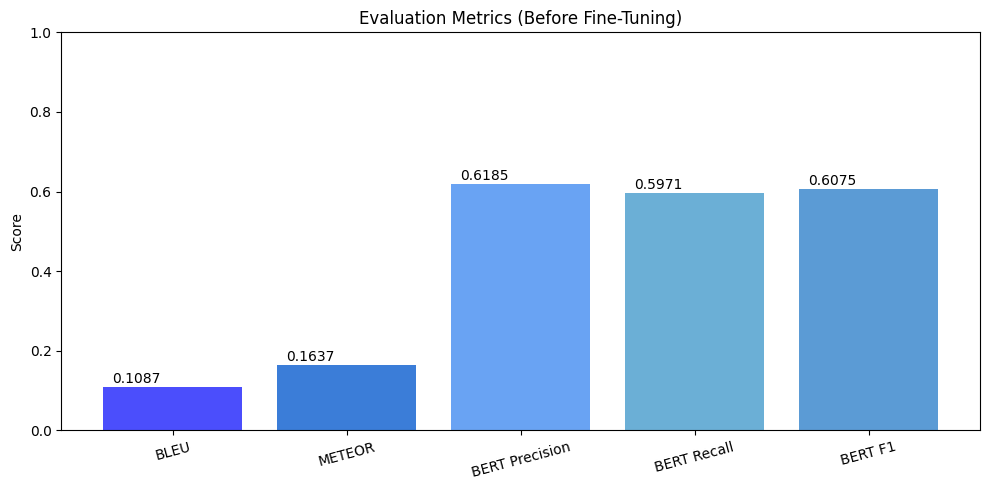

In [236]:
import matplotlib.pyplot as plt

labels = list(metrics_before.keys())
scores = list(metrics_before.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, scores, color=['#4B4EFC', '#3B7DD8', '#69A3F3', '#6BAFD6', '#5B9BD5'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.05, yval + 0.01, f"{yval:.4f}")
plt.ylim(0, 1)
plt.title("Evaluation Metrics (Before Fine-Tuning)")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [237]:
before_samples = []

for eng, ger in val_pairs[:5]:
    pred = translate_sentence(eng, model, eng_vocab, german_vocab)
    before_samples.append((eng, ger, pred))

# Print
for i, (en, gt, pr) in enumerate(before_samples):
    print(f"\nSample {i+1}")
    print(f"EN: {en}")
    print(f"GT: {gt}")
    print(f"PR: {pr}")


Sample 1
EN: You can be unlucky and have a car crash, or abuse alcohol, but with tobacco, the life-threatening aspect is always there.
GT: Mit einem Auto kann man einen Unfall haben, Alkohol kann man mißbrauchen, aber bei Tabak gibt es keine andere Möglichkeit: er ist lebensgefährlich.
PR: sie haben uns daß daß die und und und und die wir die die und und die wir uns nicht

Sample 2
EN: I very much welcome the emphasis which Mr Maaten placed on the dangers of passive smoking.
GT: Ich bin sehr erfreut, daß Kollege Maaten nachdrücklich auf die Gefahren des Passivrauchens hingewiesen hat.
PR: ich habe mich für die bericht von herrn und und und und

Sample 3
EN: A tobacco ban would be inefficient and socially unattainable at present.
GT: Ein Tabakverbot wäre derzeit nicht effizient und gesellschaftlich auch nicht durchzusetzen.
PR: das ist und die und und und

Sample 4
EN: But it still remains clear that those who market cigarettes should not be allowed to do so.
GT: Eines aber steht fest: